# Q Learning (Off Policy) on Continuous State Environment


In [28]:
# Initial imports and enviroment setup
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime
from gymnasium.wrappers import RecordVideo

In [ ]:
# Q Learning Learning agent class


class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = (
                reward
                + self.gamma * self.get_Q(next_state, best_next_action)
                - self.get_Q(state, action)
            )
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [31]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size  # max number of items in buffer
        self.buffer = []  # array to holde buffer

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        self.buffer = self.buffer[-self.size :] + [item]

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return states, actions, rewards, next_states, done_flags

In [32]:
# training algorithm with reply buffer
def train_agent(
    env,
    agent,
    episode_cnt=10000,
    tmax=10000,
    anneal_eps=True,
    replay_buffer=None,
    batch_size=16,
):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state, _ = env.reset()
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)
            if replay_buffer:
                replay_buffer.add(state, action, reward, next_state, done)
                states, actions, rewards, next_states, done_flags = (
                    replay_buffer.sample(batch_size)
                )
                for i in range(batch_size):
                    agent.update(
                        states[i], actions[i], rewards[i], next_states[i], done_flags[i]
                    )
            else:
                agent.update(state, action, reward, next_state, done)

            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

In [33]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name, np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(0, 200)
    plt.show()

In [34]:
# We will use ObservationWrapper class from gym to wrap our environment.
# We need to implement observation() method which will receive the
# original state values from underlying environment
# In observation() we will discretize the state values
# which then will be passed to outside world by env
# the agent will use these discrete state values
# to learn an effective policy using q-learning


class Discretizer(gym.ObservationWrapper):
    def observation(self, state):
        discrete_x_pos = np.round(state[0], 1)
        discrete_x_vel = np.round(state[1], 1)
        discrete_pole_angle = np.round(state[2], 1)
        discrete_pole_ang_vel = np.round(state[3], 1)
        return (
            discrete_x_pos,
            discrete_x_vel,
            discrete_pole_angle,
            discrete_pole_ang_vel,
        )

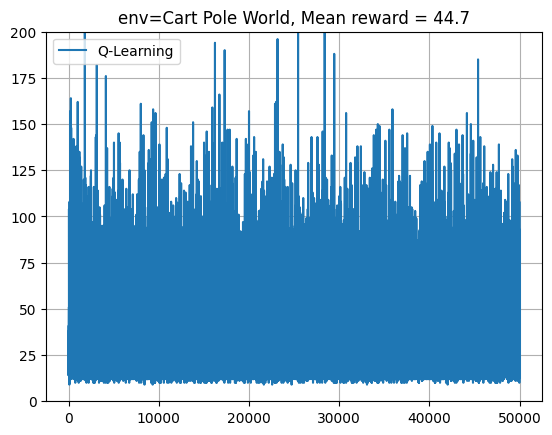

In [35]:
# create Cart Pole environment
# using .env will remove the time limit termination of 200 steps

env = gym.make("CartPole-v1")
env = env.unwrapped

# wrap our env with Discretizer
env = Discretizer(env)

# create a Q Learning agent
agent = QLearningAgent(
    alpha=0.5,
    epsilon=0.20,
    gamma=0.99,
    get_possible_actions=lambda s: range(env.action_space.n),
)

# train agent using replay buffer and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt=50000)

# plot rewards
plot_rewards("Cart Pole World", rewards, "Q-Learning")

env.close()

In [36]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = env.unwrapped
env = Discretizer(env)
timestamp = int(datetime.datetime.now().timestamp())
env = RecordVideo(env=env, video_folder="./video", name_prefix=timestamp)

rewards = train_agent(env, agent, episode_cnt=1)
env.close()